---
author: 
  - name: Matthew Reda
    email: redam94@gmail.com
license: "CC BY"
copyright: 
  holder: Matthew Reda
  year: 2024
citation: true
---

# The Illusion of Significance

> The Selection Challenge in Media Mix Modeling

## Introduction

Effective Media Mix Modeling (MMM) requires accurately controlling for numerous external factors (e.g., macroeconomic conditions, seasonality, trends, competitor actions) and determining appropriate functional forms for media effects (e.g., adstock, saturation) to isolate marketing impact and avoid omitted variable bias. Identifying these essential components frequently involves evaluating many potential factors and transformations against time-series data. A prevalent approach selects these components based on statistical significance tests (p-values, t-statistics from regression models, or correlation analysis) with the objective of identifying key sales drivers and constructing a reliable model.

Relying solely on statistical significance for this selection process, however, especially when dealing with data collected over time, encounters significant challenges, notably the potential for an illusion of significance. Selecting model components based solely on these tests undermines the reliability and standard interpretation of statistical measures like p-values and confidence intervals for the elements ultimately chosen.

This occurs because the selection process itself, when it involves conducting numerous tests on the same dataset, can inadvertently resemble problematic research practices such as **p-hacking** (analyzing data in multiple ways but only reporting results that appear significant) or **data snooping** (forming hypotheses after observing patterns in the data). Such practices violate the principles underlying standard statistical inference, particularly the assumption that hypotheses are defined before examining the data, which is essential for p-values to be interpreted correctly.

Analyzing data collected over time introduces additional complexities. For example, underlying trends (a property called non-stationarity) can create misleading correlations between unrelated variables, making them appear connected when they are not (this is known as spurious regression). Similarly, patterns that repeat over time (autocorrelation) or regular seasonal effects, if not properly addressed in the model, can invalidate the results of standard statistical tests used during the selection process, for instance, by making statistical errors appear smaller than they truly are.

Consequently, the p-values associated with selected model components often appear smaller (more significant) than they genuinely are. This can lead to overconfidence in the findings and incorrect conclusions about what influences sales. These p-values obtained after selection do not accurately reflect the true probability of observing such a strong relationship by chance, even if the time-series characteristics of the data were perfectly managed. Furthermore, focusing solely on statistical significance overlooks another important consideration: variables necessary for statistical control (to account for confounding effects between marketing and external factors) might not themselves appear statistically significant or might have estimated effects close to zero. Removing such variables simply because they lack statistical significance can be detrimental, as their inclusion might still be essential for obtaining more accurate and less biased estimates of marketing effectiveness; their primary role might be statistical adjustment, rather than having a large, directly measurable impact themselves. 

::: {.callout-warning collapse="true"}
## Consequences of this Approach
Media mix optimization and strategic media planning based on models with mis-specified factors or biased coefficients can lead to inefficient budget allocation and suboptimal marketing performance. Moreover, if confounded macroeconomic factors shift, recommendations derived from such flawed models may prove particularly unreliable, as the model might misinterpret the impact of these external changes.
:::

::: {.callout-tip collapse="false"}
## Analogy
Imagine interviewing thousands of people to understand typical financial habits. If you only seek out and report on the experiences of those who recently won a major lottery, your conclusions about 'typical' financial success would be extremely misleading. You selected them precisely because they had an exceptionally rare, positive outcome (winning the lottery). Similarly, when numerous statistical tests are performed on potential model components (factors or transformations), finding one that meets a 'significance' threshold (like winning the lottery) is more likely simply because many tests were run. The resulting p-value loses its standard meaning because the selection process focused on finding an extreme or 'lucky' result from many possibilities, rather than reflecting the probability of such a finding under normal circumstances.
:::



## Core Statistical Challenges in MMM Selection
The selection of factors and transformations in MMM faces a confluence of statistical difficulties:

- **Multiple Testing Problem:** Simultaneously testing numerous potential external factors and functional forms for media variables drastically increases the probability of false positives (Type I errors). Standard significance thresholds (e.g., p < 0.05) are inadequate for controlling the overall error rate across such extensive testing.

- **Post-Selection Inference (PSI) Invalidity:** Standard statistical inference (p-values, confidence intervals) lacks theoretical validity when applied after model components have been selected using the same data. These post-selection metrics are often biased (e.g., p-values too small, confidence intervals too narrow), failing to maintain their nominal error rates or coverage probabilities.

- **Time-Series Complications:** MMM data's time-series nature introduces further challenges:

    - *Autocorrelation:* Residuals are often correlated over time, violating standard regression assumptions and rendering OLS p-values inaccurate.

    - *Non-stationarity:* Trends in variables can lead to spurious regression—finding significant relationships where none exist causally.

    - *Seasonality:* Unaccounted-for seasonal patterns can induce spurious correlations. These properties can invalidate the significance tests used during selection, compounding the problem.

### Multiple Testing Problem

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(46)

def simulate_multiple_testing():
    """
    Simulate testing many unrelated variables and counting false positives
    """
    n = 156  # Two years of weekly data
    true_significant = []
    
    # Generate outcome variable (sales)
    sales = 300 + np.random.normal(0, 1, n) # Random walk
    
    # Generate 100 completely random potential predictors
    # These have NO relationship with sales by construction
    n_vars = 100
    random_predictors = pd.DataFrame(
        np.random.normal(0, 1, (n, n_vars)),
        columns=[f'random_var_{i}' for i in range(n_vars)]
    )
    
    predictors_selected = list(random_predictors.columns)

    N_TESTS = 1000
    significant_predictors = predictors_selected
    
    for _ in range(N_TESTS):
        # Randomly select predictors to test
        if len(predictors_selected) < 1:
            # Randomly select 20 predictors
            break
        
        selected_predictors = significant_predictors
        
        # Fit a linear regression model for each selected predictor
        
        X = sm.add_constant(random_predictors[selected_predictors])
        model = sm.OLS(sales, X).fit()
        p_values = model.pvalues.iloc[1:]  # Exclude the constant term
        significant_predictors = np.array(selected_predictors)[p_values <= 0.05].tolist()

    selected_predictors = significant_predictors
    X = sm.add_constant(random_predictors[selected_predictors])
    
    model = sm.OLS(sales, X).fit()
    print(model.summary())
    p_values = model.pvalues.iloc[1:]


    # Count "significant" findings at alpha = 0.05
    sig_count = sum(p < 0.05 for p in p_values)
    
    return {
        'p_values': p_values,
        'significant_count': sig_count,
        'expected_false_positives': 0.05 * n_vars
    }

# Visualization of results
def plot_multiple_testing_results(results):
    plt.figure(figsize=(10, 6))
    sns.histplot(results['p_values'], bins=20, kde=True)
    plt.axvline(0.05, color='red', linestyle='--', label='α = 0.05')
    plt.title(f"Distribution of p-values from 100 unrelated variables\n"
              f"Found {results['significant_count']} 'significant' results (Expected: {results['expected_false_positives']})")
    plt.xlabel('p-value')
    plt.ylabel('Count')
    plt.legend()
    

In [5]:
def simulate_multiple_data(seed=42):
    """
    Simulate testing many unrelated variables and counting false positives
    """
    n = 156  # Two years of weekly data
    true_significant = []
    np.random.seed(seed)
    # Generate outcome variable (sales)
    true_walk = np.random.normal(0, 3, n).cumsum()
    trend = np.linspace(0, 1, n)
    seasonal_comp = np.sin(np.linspace(0, 3*2 * np.pi, n))
    sales = (
        300 
        + 4*true_walk # Random walk
        + np.random.normal(0, 1, n)*10 # Random noise
        + trend * 150 # Deterministic Linear trend
        + seasonal_comp * 20 # Seasonal component
        )  
    
    # Generate 100 completely random potential predictors
    # These have NO relationship with sales by construction
    n_vars_whitenoise = 50
    random_predictors = pd.DataFrame(
        np.random.normal(0, 1, (n, n_vars_whitenoise)),
        columns=[f'random_var_{i}' for i in range(n_vars_whitenoise)]
    )
    n_vars_randomwalk = 25
    random_walks = pd.DataFrame(
        np.random.normal(0, 1, (n, n_vars_randomwalk)).cumsum(axis=0),
        columns=[f'random_walk_{i}' for i in range(n_vars_randomwalk)]
    )
    n_vars_trending = 25
    trending = pd.DataFrame(
        np.random.normal(0, 1, (n, n_vars_trending)) + np.linspace(0, 1, n)[:, None]*np.random.normal(0, 1, n_vars_trending)[None, :],
        columns=[f'random_trending_{i}' for i in range(n_vars_trending)]
    )
    n_vars_seasonal = 25
    seasonal = pd.DataFrame(
        (np.random.normal(0, .1, (n, n_vars_seasonal)) 
        + (
            (
                np.sin(
                    (np.arange(4)+1)[None, :]*np.linspace(0, 3*2 * np.pi, n)[:, None]
                )
                * np.random.normal(0, 1, 4)[None, :]
            ).sum(axis=-1)
        )[:, None]*np.random.normal(0, 1, n_vars_seasonal)[None, :]
        ),
        columns=[f'random_seasonal_{i}' for i in range(n_vars_seasonal)]
    )
    random_predictors['sales'] = sales
    predictors = pd.concat([random_predictors, random_walks, trending, seasonal], axis=1)
    predictors['true_trend'] = trend
    predictors['true_seasonal'] = seasonal_comp
    predictors['true_walk'] = true_walk
    return predictors


In [6]:
def run_stepwise_selection(data, add_media=True):
    """
    Demonstrate naive stepwise selection
    """
    from statsmodels.regression.linear_model import OLS
    
    # Get all predictor columns (everything except sales)
    predictors = [col for col in data.columns if ((col != 'sales') and (not 'media' in col))]

    # Start with an empty model
    current_predictors = []
    remaining_predictors = predictors.copy()
    
    # Forward stepwise selection
    max_steps = 50  # Limit number of steps
    step_results = []
    
    for step in range(max_steps):
        best_pvalue = float('inf')
        best_predictor = None
        
        # Try each remaining predictor
        for predictor in remaining_predictors:
            # Add this predictor to current set
            test_predictors = current_predictors + [predictor]
            
            # Build model with current + candidate predictor
            if add_media:
                # Include media variables in the model
                X = sm.add_constant(data[test_predictors + ['adstocked_media1', 'adstocked_media2']])
            else:
                # Exclude media variables from the model
                X = sm.add_constant(data[test_predictors])
            model = sm.OLS(data['sales'], X).fit()
            
            # Get p-value for this candidate predictor
            p_value = model.pvalues.loc[predictor]
            
            if p_value < best_pvalue and p_value < 0.05:
                best_pvalue = p_value
                best_predictor = predictor
        
        # If we found a significant predictor, add it
        if best_predictor:
            current_predictors.append(best_predictor)
            remaining_predictors.remove(best_predictor)
            
            # Run model with updated predictors
            if add_media:
                X = sm.add_constant(data[current_predictors + ['adstocked_media1', 'adstocked_media2']])
            else:
                X = sm.add_constant(data[current_predictors])
            model = sm.OLS(data['sales'], X).fit()
            
            # Record results
            step_results.append({
                'step': step + 1,
                'added_predictor': best_predictor,
                'predictors': current_predictors.copy(),
                'r_squared': model.rsquared,
                'adj_r_squared': model.rsquared_adj,
                'aic': model.aic,
                'bic': model.bic,
                'model': model
            })
        else:
            # No more significant predictors
            break
    
    return step_results

In [7]:
data = simulate_multiple_data(seed=102)
train_data = data.iloc[:104]
results = run_stepwise_selection(train_data, add_media=False)
prediction = results[-1]['model'].predict()
results[-1]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     181.9
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           1.27e-58
Time:                        10:59:52   Log-Likelihood:                -349.41
No. Observations:                 104   AIC:                             726.8
Df Residuals:                      90   BIC:                             763.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                291.3959      2.895    100.670      0.000     285.645     297.147
true_walk              4.1653      0.115     36.340      0.000       3.938       4.393
true_trend           178.9716      9.793     18.275      0.000     159.516     198.427
true_seasonal         21.5564      1.231     17.511      0.000      19.111      24.002
random_var_25          3.0998      0.734      4.224      0.000       1.642       4.558
random_var_31          4.9689      1.007      4.933      0.000       2.968       6.970
random_walk_9         -2.0130      0.458     -4.393      0.000      -2.923      -1.103
random_var_30         -3.0752      0.791     -3.887      0.000      -4.647      -1.503
random_trending_8     -2.7992      0.896     -3.123      0.002      -4.580      -1.018
random_trending_13     2.3075      0.855      2.700      0.008       0.610       4.005
random_var_42          2.2198      0.871      2.550      0.012       0.490       3.950
random_var_46          2.3157      0.886      2.615      0.010       0.556       4.075
random_trending_16     1.8285      0.841      2.174      0.032       0.158       3.499
random_var_26         -1.5485      0.771     -2.008      0.048      -3.080      -0.017
==============================================================================
Omnibus:                        0.796   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.672   Jarque-Bera (JB):                0.851
Skew:                           0.201   Prob(JB):                        0.653
Kurtosis:                       2.813   Cond. No.                         135.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
X = sm.add_constant(data.iloc[104:][results[-1]['predictors']])
test_prediction = results[-1]['model'].predict(X)

In [9]:
adfuller_test = adfuller(data['sales'])
if (pvalue := adfuller_test[1])>0.05:
    print(f"Can't reject a unit root (p-value: {pvalue:.4f})")
else:
    print(f"Reject a unit root (p-value: {pvalue:.4f})")

Can't reject a unit root (p-value: 0.8771)


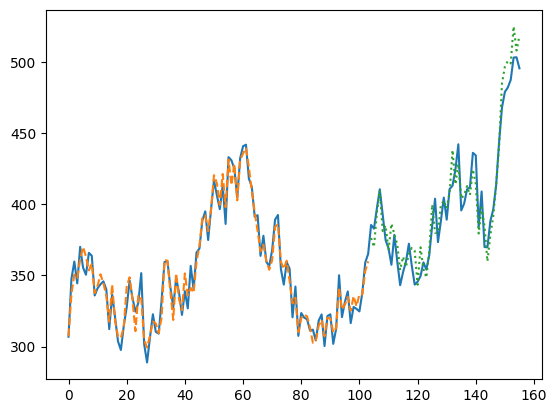

In [71]:
demeaned_sales = (data['sales']-np.mean(data['sales']))
std_sales = demeaned_sales/np.std(data['sales'], ddof=1)
demeaned_prediction = (prediction-np.mean(data['sales']))
std_prediction = demeaned_prediction/np.std(data['sales'], ddof=1)
test_prediction_demeaned = (test_prediction-np.mean(data['sales']))
std_test_prediction = test_prediction_demeaned/np.std(data['sales'], ddof=1)
demeaned_random_walk_9 = (data['random_walk_9']-np.mean(data['random_walk_9']))
std_random_walk_9 = demeaned_random_walk_9/np.std(data['random_walk_9'], ddof=1)
demeaned_random_seasonal = data['random_seasonal_1']-np.mean(data['random_seasonal_1'])
std_random_seasonal = demeaned_random_seasonal/np.std(data['random_seasonal_1'], ddof=1)


plt.plot(data['sales'], label='Sales')
plt.plot(prediction, label='Predicted Sales', linestyle='--')
plt.plot(np.arange(104, 156), test_prediction, label='Test Prediction', linestyle=':')
#plt.plot(std_random_seasonal, label='Random Seasonal 0', linestyle='-.')
#plt.plot(std_random_walk_9, label='Random Walk 9', linestyle=':')

In [11]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [80]:
lasso = LassoCV(cv=10, alphas=np.logspace(-1, 2, 100), random_state=0)
scaler = StandardScaler()
pipeline = make_pipeline(scaler, lasso)
fitted_pipeline = pipeline.fit(train_data.drop(columns=['sales']), train_data['sales'])

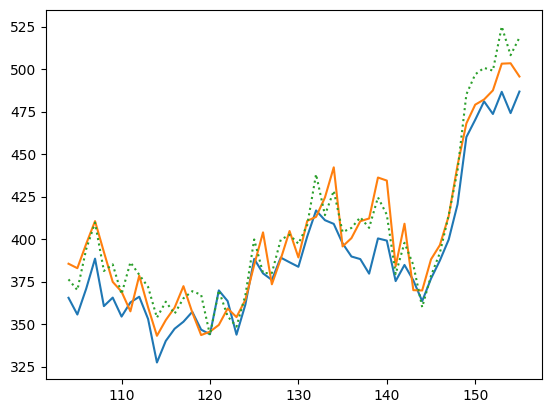

In [81]:
plt.plot(np.arange(104, 156), fitted_pipeline.predict(data.iloc[104:].drop(columns=['sales'])))
plt.plot(data.iloc[104:]['sales'])
plt.plot(np.arange(104, 156), test_prediction, label='Test Prediction', linestyle=':')

In [92]:
lasso.alpha_

np.float64(0.464158883361278)

In [14]:
import pymc as pm

In [42]:
coords = {
    'predictors': train_data.drop(columns=['sales']).columns,
    'index': np.arange(len(train_data))
}
# Standardize the data

indep_scaler = StandardScaler()
dep_scaler = StandardScaler()
scaled_data = indep_scaler.fit_transform(train_data.drop(columns=['sales']).values)
scaled_target = dep_scaler.fit_transform(train_data['sales'].values.reshape(-1, 1)).flatten()

D = len(coords['predictors'])
D0 = 3
N = len(train_data)
with pm.Model(coords=coords) as model:
    # Define regularized horeshoe prior for coefficients
    X = pm.Data("X", scaled_data, dims=('index', 'predictors'))
    sigma = pm.HalfNormal('sigma', 1)
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    lam = pm.HalfStudentT("lam", 5, dims='predictors')
    c2 = pm.InverseGamma("c2", 1, 1)
    lam_ = pm.Deterministic('var', tau * lam * pm.math.sqrt(c2 / (c2 + tau**2 * lam**2)), dims='predictors')

    z = pm.Normal("z", 0., 1., dims='predictors')
    beta = pm.Deterministic("beta", z * lam_, dims='predictors')
    intercept = pm.Normal("intercept", 0, 1.)

    obs = pm.Normal("obs", intercept + pm.math.dot(X, beta), sigma, dims='index')


In [43]:
with pm.observe(model, {'obs': scaled_target}):
    trace = pm.sample(1000, tune=1000, cores=4, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, intercept]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [44]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [45]:
import xarray as xr

<Axes: >

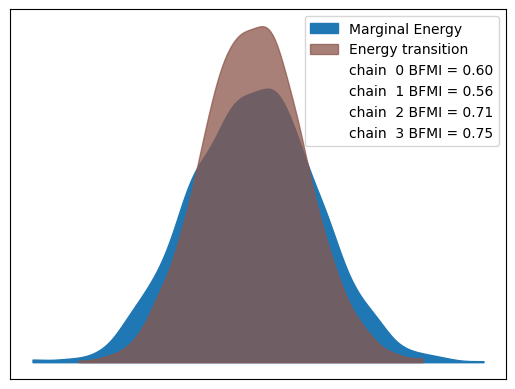

In [46]:
pm.plot_energy(trace)

In [47]:
trace.posterior['beta_scaled'] = xr.DataArray(dep_scaler.scale_/indep_scaler.scale_, coords={
    'predictors': coords['predictors']
}, dims='predictors')*trace.posterior['beta']

In [69]:
subset_trace = trace.posterior['beta_scaled'][(np.abs(trace.posterior['beta_scaled'].mean(dim=('chain', 'draw'))/trace.posterior['beta_scaled'].std(dim=('chain', 'draw')))>1)]
new_subset_trace = trace.posterior['beta_scaled'][(np.abs(trace.posterior['beta'])/trace.posterior['var']).mean(dim=('chain', 'draw'))>1]
new_subset_unscaled = trace.posterior['beta'][:, :, (np.abs(trace.posterior['beta'])/trace.posterior['var']).mean(dim=('chain', 'draw'))>1]

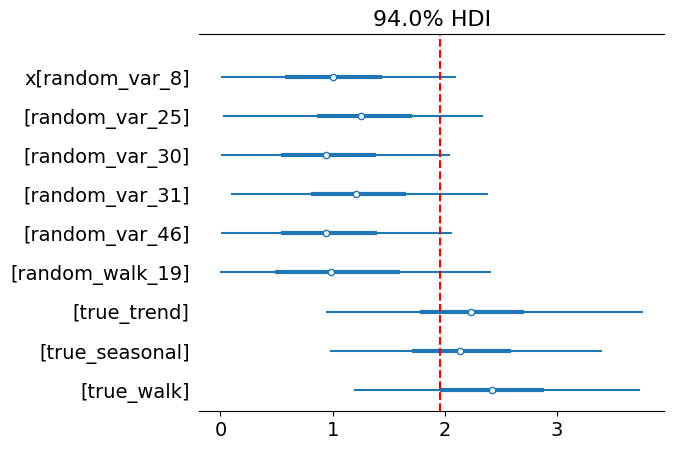

In [70]:
pm.plot_forest(
    (np.abs(new_subset_unscaled)/trace.posterior['var']),
    #kind="ridgeplot", 
    combined=True, 
    ridgeplot_truncate=True)
plt.axvline(1.96, color='red', linestyle='--')

array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

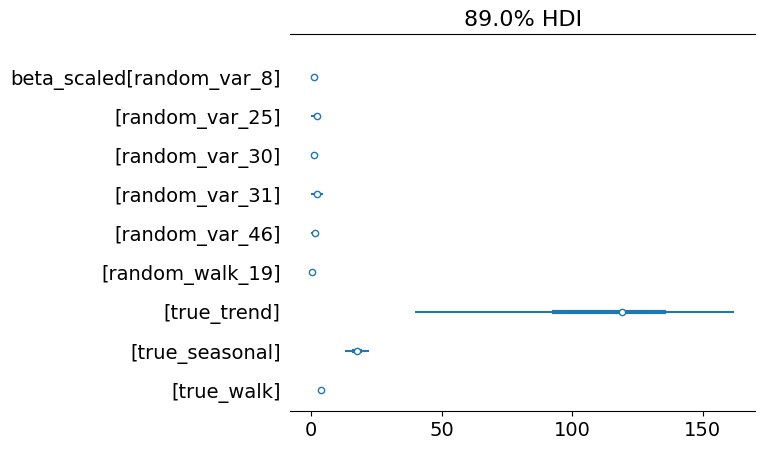

In [62]:
pm.plot_forest(
    np.abs(new_subset_trace).isel(draw=slice(0,1000, 10)),
    #kind="ridgeplot", 
    combined=True, 
    ridgeplot_truncate=True,
    hdi_prob=0.89,)
#plt.axvline(1.96, color='red', linestyle='--')

In [30]:
summary = pm.summary(trace.isel(draw=slice(0, 1000, 10)), var_names=['beta_scaled'], hdi_prob=0.89)
summary[summary['mean']/summary['sd'] > 1].sort_values('mean', ascending=False)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_scaled[true_trend],109.228,36.447,61.766,161.148,1.995,2.011,366.0,310.0,1.00
beta_scaled[true_seasonal],17.274,3.014,12.148,21.501,0.155,0.138,395.0,362.0,1.00
beta_scaled[true_walk],3.863,0.218,3.532,4.210,0.011,0.009,376.0,375.0,1.00
beta_scaled[random_var_31],2.321,1.330,0.018,4.188,0.064,0.036,430.0,411.0,1.00
beta_scaled[random_var_25],2.051,1.152,0.154,3.821,0.061,0.034,356.0,443.0,1.00
beta_scaled[random_var_46],1.479,1.234,-0.128,3.496,0.062,0.035,402.0,371.0,1.00
beta_scaled[random_var_8],1.234,0.937,-0.124,2.589,0.050,0.024,332.0,312.0,1.01
beta_scaled[random_var_5],1.069,1.015,-0.343,2.622,0.047,0.030,463.0,373.0,1.00
beta_scaled[random_var_24],0.833,0.807,-0.273,2.066,0.038,0.030,482.0,417.0,1.00


In [102]:
lower = trace.posterior['beta_scaled'].sel(predictors='true_trend').quantile(.1, dim=("chain", 'draw')).values.item()
upper = trace.posterior['beta_scaled'].sel(predictors='true_trend').quantile(.9, dim=("chain", 'draw')).values.item()

(lower, upper)

(35.1853005241653, 145.03447145593393)

array([[<Axes: title={'center': 'beta_scaled'}>,
        <Axes: title={'center': 'beta_scaled'}>]], dtype=object)

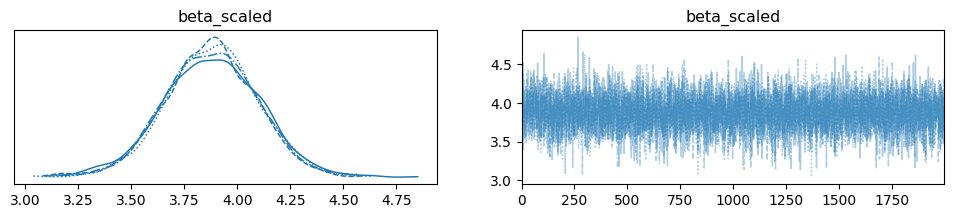

In [103]:
pm.plot_trace(trace.posterior['beta_scaled'].sel(predictors='true_walk'))

### Post-Selection Inference (PSI) Invalidity

### Time-Series Complications

## Common Problematic Selection Practices in MMM
Several widely used methodologies are particularly susceptible to the challenges outlined above:

- **Stepwise Regression:** Automated procedures (forward, backward, bidirectional) iteratively add/remove variables based on significance thresholds. These are highly prone to multiple testing errors and instability, especially with autocorrelated or non-stationary time-series data, potentially selecting variables based on spurious correlations or invalid tests.

- **Significance-Based Transformation Selection:** Testing numerous functional forms (e.g., hundreds of adstock decays or saturation curves) for each media variable and selecting the one yielding the "most significant" coefficient represents a severe form of multiple testing, risking the selection of forms that fit noise.

- **Correlation Screening / Univariate Tests:** Selecting external factors based on simple correlations or individual significance tests ignores multicollinearity and is highly vulnerable to spurious findings driven by trends or seasonality, while also failing to account for multiple comparisons.

- **Best Subset Selection:** While potentially better if using information criteria (AIC/BIC), evaluating numerous model subsets still incurs a multiple testing burden and remains vulnerable to underlying time-series issues if not properly addressed within the model structure.

## Consequences of Flawed Selection in MMM
Employing naive selection methods and subsequent inference leads to significant practical problems:

- **Misattribution of ROI & Effects:** Biased estimates for marketing coefficients (ROI) and potentially inaccurate representations of media dynamics (adstock, saturation).

- **Flawed Budget Allocation:** Suboptimal marketing investment decisions stemming from unreliable ROI figures.

- **Poor Understanding of Business Drivers:** Incorrect identification of baseline factors (trends, seasonality, macroeconomics) and media response patterns.

- **Model Instability & Non-Reproducibility:** Selected factors and transformations may vary considerably with data updates, reducing model credibility.

- **Overfitting:** Models capture noise specific to the historical data, resulting in poor predictive performance for forecasting or simulations.

- **Misinterpretation of Control Factor Coefficients:** Attributing causal effects to the coefficients of baseline or control factors (e.g., macroeconomic variables, competitor activity) included in the model. These factors are typically observational and likely confounded themselves; their coefficients primarily reflect statistical association and adjustment needed to isolate media effects, not necessarily isolated causal impacts. This misinterpretation is related to the "Table 2 fallacy," where coefficients from a multivariable model are improperly treated as independent causal effects.

## Recommended Approaches and Considerations
Addressing these challenges requires more robust methodologies:

- **Rigorous Time-Series Handling:** Explicitly model or remove seasonality (e.g., dummies, Fourier terms, decomposition); test for and address non-stationarity (e.g., differencing); incorporate theoretically sound lags for media (adstock) and potentially external variables.

- **Regularization Methods (LASSO, Ridge, Elastic Net):** Handle many predictors simultaneously, perform coefficient shrinkage and implicit variable selection, often yielding more stable results than stepwise methods. Must be applied in conjunction with appropriate time-series structures.

- **Information Criteria (AIC, BIC):** Use for comparing non-nested models that correctly account for time-series properties, providing a more principled approach than p-value thresholds alone.

- **Time-Series Cross-Validation:** Employ methods like rolling-origin validation to assess out-of-sample predictive performance robustly.

- **Bayesian Frameworks:** Offer a probabilistic approach to uncertainty.

    - *Priors on Functional Forms:* Incorporate prior knowledge or average over plausible media transformations (adstock/saturation) instead of hard selection.

    - *Sparsity-Inducing Priors (e.g., Regularized Horseshoe):* Provide principled variable selection for external factors by shrinking irrelevant coefficients while retaining influential ones, directly modeling inclusion uncertainty.

- **Causal Inference Techniques:** Explore advanced time-series methods if the primary goal is establishing causal links (use with caution).

- **Domain Knowledge & Theory:** Prioritize pre-selecting candidate factors and transformation ranges based on business logic, economic theory, and prior research. Validate final model components for plausibility and stability.

::: {.callout-important}
## Improper Use of Domain Knowledge
Exogenous factors in MMM are frequently confounded with media variables or other unobserved drivers. Consequently, the estimated coefficient for an exogenous variable may not represent its direct causal impact on the outcome but rather the statistical adjustment necessary to deconfound the estimated media effects. Rejecting such a variable because its coefficient sign contradicts simple causal expectations might inadvertently remove a necessary control variable, potentially leading to more biased estimates of media effectiveness.
:::
Adopting these more rigorous approaches is fundamental to developing media mix models that are statistically sound, reliable, and strategically valuable.